In [190]:
import torch 
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataloader import DataLoader
from meta_learning.datasets import SinusoidalDataset, Sinusoid
from meta_learning.utils import acc_regression, save
from meta_learning.models import SimpleMLP
from meta_learning.meta_grads import maml_grad
import random
import copy
import matplotlib.pyplot as plt


nways = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

#%%
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
bsize_outer = 16
bsize_inner = 32
dataset = SinusoidalDataset(bsize_outer=bsize_outer, bsize_inner=bsize_inner)
loader = torch.utils.data.DataLoader(dataset, batch_size=None, num_workers=4, batch_sampler=None)

In [155]:
model = SimpleMLP([1, 64, 64, 1]).to(device)


In [172]:
opt_outer = torch.optim.Adam(model.parameters(), lr=3e-3)

In [173]:
eps=1000
# ii = 0
# writer = SummaryWriter('tb/maml_grad_sin_relu_'+str(random.random()))
for ep in range(eps):
    for step, (x, y) in enumerate(loader):
        xexamples, xtoguess = x[:, :-1], x[:, -1].unsqueeze(1)
        yexamples, ytoguess = y[:, :-1], y[:, -1].unsqueeze(1)
        opt_outer.zero_grad()
        loss, accuraccy = maml_grad(model, xexamples, yexamples, xtoguess, ytoguess, 0.5e-2, classification=False, device=device)
        opt_outer.step()
        writer.add_scalar('metric/loss', loss, ii := ii+1)
        writer.add_scalar('metric/accu', accuraccy, ii)
        import time 
        time.sleep(5)
        if step % 10 == 0:
            save(model, "maml_sine_relu", ep, step)
    print(ep, step, loss, accuraccy)

KeyboardInterrupt: 

# Testing

In [13]:
for x, y in loader_test:
    break
xexamples, xtoguess = x[:, :-1], x[:, -1].unsqueeze(1)
yexamples, ytoguess = y[:, :-1], y[:, -1].unsqueeze(1)

NameError: name 'loader_test' is not defined

## Untrained net on 3 grad steps
### accuracy = 0.273

In [24]:
reptile_optimize(SimpleCNN(nways), xexamples, yexamples, xtoguess, ytoguess, 1e-2, 5, 0.9, update_model=False)

(0.34665910596959293,
 0.33203125,
 tensor([[[0.2634, 0.2669, 0.2455, 0.2242],
          [0.2630, 0.2673, 0.2455, 0.2242],
          [0.2638, 0.2665, 0.2454, 0.2243],
          [0.2631, 0.2672, 0.2454, 0.2243]]], grad_fn=<ViewBackward>))

## Trained net on 5 grad steps
### accuracy = 0.633

In [23]:
reptile_optimize(model, xexamples, yexamples, xtoguess, ytoguess, 1e-2, 5, 0.9, update_model=False)

(0.3388259964995086,
 0.439453125,
 tensor([[[0.0235, 0.2753, 0.1898, 0.5114],
          [0.0102, 0.2851, 0.1641, 0.5406],
          [0.0086, 0.2796, 0.1751, 0.5366],
          [0.0035, 0.2529, 0.1336, 0.6100]]], grad_fn=<ViewBackward>))

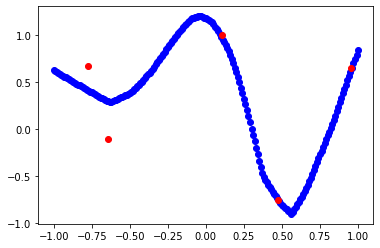

0.06037772446870804

In [189]:
# x, y = Sinusoid(1, 1, 1).get_sample(5, minx=-1, maxx=1)
x.squeeze_(0)
y.squeeze_(0)
model2 = copy.deepcopy(model).to(torch.device('cpu'))
model2 = SimpleMLP([1, 256, 256, 1])

lloss = []
opt = torch.optim.Adam(model2.parameters(), lr=10e-2)
for i in range(70):
    loss = ((y - model2(x))**2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    lloss.append(loss.item())
x2 = torch.range(-1, 1, 1/100).unsqueeze(-1)
plt.scatter(x2.numpy(), model2(x2).detach().numpy(), c='b')
plt.scatter(x.numpy(), y.numpy(), c='r')
plt.show()
lloss[-1]

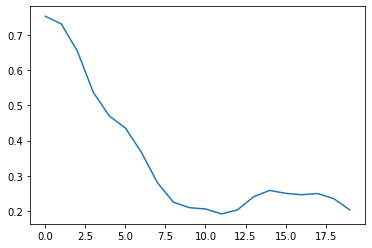

In [74]:
plt.plot(lloss[-20:])

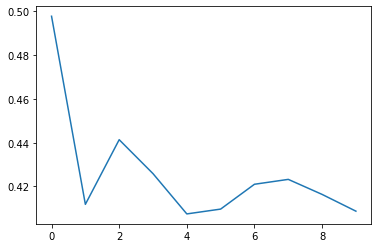

In [86]:
plt.plot(lloss)

In [186]:

x, y = Sinusoid(1, 1, 1).get_sample(100, minx=-1, maxx=1)
x2 = torch.range(-1, 1, 1/100).unsqueeze(-1)
x.squeeze_(0)
y.squeeze_(0)
model2 = copy.deepcopy(model).to(torch.device('cpu'))
model3 = SimpleMLP([1, 8, 8, 1])
lloss2 = []
lloss3 = []
opt2 = torch.optim.Adam(model2.parameters(), lr=1e-1)
opt3 = torch.optim.Adam(model3.parameters(), lr=1e-1)
for step in range(200):
    loss2 = ((y - model2(x))**2).mean()
    loss3 = ((y - model3(x))**2).mean()
    opt2.zero_grad()
    opt3.zero_grad()
    loss2.backward()
    loss3.backward()
    opt2.step()
    opt3.step()
    lloss2.append(loss2.item())
    lloss3.append(loss3.item())
    plt.ylim([-1.5, 1.5])
    plt.xlabel("iteration number " + str(step))
    plt.scatter(x2.numpy(), model2(x2).detach().numpy(), c='b')
    plt.scatter(x2.numpy(), model3(x2).detach().numpy(), c='black')
    plt.scatter(x.numpy(), y.numpy(), c='r')
    plt.savefig('imgs/sine'+str(step)+'.jpg')
    plt.clf()
    plt.ylim(auto=True)
    plt.plot(lloss2, c='b')
    plt.plot(lloss3, c='black')
    plt.savefig('imgs/loss'+str(step)+'.jpg')
    plt.clf()
    if step%10==0:
        print(step)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


<Figure size 432x288 with 0 Axes>